# Analyze dwell times (notebook 5)

> Chris Kimmel | kimmel.95@osu.edu | 8/12/2020

This notebook compares positional dwell-time distributions in the vicinities of three putative modification sites on the HIV genome. (Positions 8078, 8710, 8974, using zero-based indexing.)
At each modification site, we compare dwell-time distributions across three sets of reads:
* IVT reads (aka "f1f2_GL")
* Trizol OLD reads for which the current-level $p$-values at the putative modification site are significant
* The other Trizol OLD reads, for which said $p$-value is insignificant

This notebook produces only plots.

> **Input:**
> * Per-read per-position current-level $p$-values from the Trizol OLD sequencing run
> * Per-read per-position dwell times from the Trizol OLD sequencing run
> * Per-read per-position dwell-tmes from the IVT sequencing run (aka "f1f2_GL")
>
> **Output:**
> * For reach of the three putative modification sites,
>  * For the 21 positions from -5 to +15,
>   * Side-by-side box-and-whisker plots of positional dwell-time distributions from these reads:
>    * Trizol OLD with significant $p$-value at putative modification site
>    * Trizol OLD with insignificant $p$-value at putative modification site
>    * IVT (aka "f1f2_GL")

I'm not sure how best to organize the box and whisker plots.
They're parameterized by three dimensions:
* dwell-time (continuous)
* position (integer)
* set of reads (categorical: f1f2_GL, Trizol_OLD_significant, and Trizol_OLD_insignificant)

I'll put dwell-time on the y-axis and position on the x-axis. I'll distinguish sets of reads by color.
I'm worried the x-axis will get overloaded, so I'll make four graphs: one with all three sets of reads, and one each of every pair of sets of reads.
And I'll just bite the bullet and try [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html) for this.

---

In [75]:
from os import environ, path
import sys
import shutil

import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set(style='darkgrid')

from tombo import tombo_helper, tombo_stats

In [2]:
putative_sites = [8078, 8710, 8974]

To make things faster, let's try copying our input data onto our compute node's local filesystem.

In [8]:
def copy_to_node(src_path):
    '''
    Copy a file to local storage on the current compute node. (I don't know
    if this would work for Jupyter Notebook sessions running on multiple
    nodes.)
    
    Args:
        src_path (str): filepath to the file to be copied
    
    Returns:
        str: Absolute path to the new file location
    '''
    print('Copying {}...'.format(src_path))
    src_basename = path.basename(src_path)
    node_path = environ['TMPDIR'] # environment variable (local node directory)
    dest_path = path.join(node_path, src_basename)
    if path.isdir(src_path):
        if path.exists(dest_path):
            shutil.rmtree(dest_path)
        shutil.copytree(src_path, dest_path)
    else:
        shutil.copyfile(src_path, dest_path)
    print('...copied to {}'.format(dest_path))
    return dest_path

## Load dwell times for Trizol_OLD and f1f2_GL

In [4]:
dwell_csv_paths = {
    'trizol_OLD': '/fs/project/PAS1405/extract_dwells_3/Trizol_OLD_8K_single_fast5_dwells.csv',
    'f1f2_GL': '/fs/project/PAS1405/extract_dwells_3/f1f2_GL_dwells.csv'
}
dwell_csv_paths = {k: copy_to_node(v) for k, v in dwell_csv_paths.items()}

Copying /fs/project/PAS1405/extract_dwells_3/f1f2_GL_dwells.csv...
...copied to /tmp/pbstmp.10948742/f1f2_GL_dwells.csv
Copying /fs/project/PAS1405/extract_dwells_3/Trizol_OLD_8K_single_fast5_dwells.csv...
...copied to /tmp/pbstmp.10948742/Trizol_OLD_8K_single_fast5_dwells.csv


In [5]:
def load_dwell_csv(csv_path):
    '''
    Load a CSV of per-read per-position dwell times into a dataframe.
    
    Args:
        csv_path (str): path to the CSV file
    
    Returns:
        pd.DataFrame: a dataframe containing FLOAT dwell times
            * rows labeled by read_id (str)
            * columns labeled by genomic position number (int)
    '''
    retval = (
        pd.read_csv(csv_path, header=0, index_col=0)
        .rename_axis('read_id', axis=0)
        .rename_axis('pos', axis=1)
    )
    retval.columns = retval.columns.astype(int)
    return retval

In [6]:
dwell_tables = {}
for key in dwell_csv_paths.keys():
    print('loading {}...'.format(key))
    dwell_tables[key] = load_dwell_csv(dwell_csv_paths[key])
    print('{} loaded'.format(key))

loading f1f2_GL...
f1f2_GL loaded
loading trizol_OLD...
trizol_OLD loaded


## Load per-read current-level $p$-values for Trizol_OLD

So I don't know where the per-read current-level p-values for Trizol_OLD are.
I'm going to re-run prsconv2.py from this notebook.
The cleanest way to do this is to import some python functions from the prsconv2.py script, and run them from this notebook.

In [9]:
# This code block is unused. I'm not sure why I wrote it.
trizol_OLD_fast5_basedir = '/fs/project/PAS1405/GabbyLee/project/m6A_modif/sequencing_data/Trizol_OLD/Trizol_OLD_8K_single_fast5'
trizol_OLD_fast5_basedir = copy_to_node(trizol_OLD_fast5_basedir)

Copying /fs/project/PAS1405/GabbyLee/project/m6A_modif/sequencing_data/Trizol_OLD/Trizol_OLD_8K_single_fast5...
...copied to /tmp/pbstmp.10948742/Trizol_OLD_8K_single_fast5


In [10]:
prsconv2_dir_path = '/fs/project/PAS1405/prsconv2/'
sys.path.append(prsconv2_dir_path) # necessary so Python can find the file
import prsconv2

In [11]:
# Stupid Python thing:
# So prsconv2 has an "import pandas as pd" statement, but this statement
# occurs inside the "if __name__ == '__main__'" block. So when we import
# prsconv2, pandas isn't imported into the prsconv2 namespace. Because of that,
# we have to add it ourselves right here:
prsconv2.pd = pd

# I just fixed this in the "master" branch of the prsconv2 project, but I'm
# not going to push anything at all to the "stable" branch without testing.

In [12]:
# cell takes less than 1 minute to run on a whole node from the Owens cluster

prs_path = '/fs/project/PAS1405/GabbyLee/project/m6A_modif/Trizol_OLD/Trizol_OLD_8K.tombo.per_read_stats'

reg = tombo_helper.intervalData(
    chrm='truncated_hiv_rna_genome',
    start=0,
    end=10**9, # I would make it infinite if I could; we want every position!
    strand='+',
)

prs_recarray = (
    tombo_stats.PerReadStats(prs_path).get_region_per_read_stats(reg)
)

# Save output to CSV in the node's local filesystem
prs_csv_path = path.join(environ['TMPDIR'], 'Trizol_OLD_8K.tombo.per_read_stats.csv')
prsconv2.recarray_to_csv(prs_recarray, prs_csv_path)

# Maybe we could have gotten the dataframe directly from prsconv2 without
# printing it to a CSV. I don't know.

/users/PAS1405/kimmel/.conda/envs/tombo2/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [13]:
prs = pd.read_csv(prs_csv_path, header=0, index_col=0)
prs.columns = prs.columns.astype(int)
prs.head()

,10,11,12,13,14,15,16,17,18,19,...,9158,9159,9160,9161,9162,9163,9164,9165,9166,9167
read_id,,,,,,,,,,,,,,,,,,,,,
00676bde-4b93-45bb-a850-c333e08c9927,NaN,NaN,NaN,NaN,NaN,NaN,0.891714,0.917194,0.890864,0.907169,...,0.661625,0.743775,0.781075,0.898235,0.980653,0.995298,0.872926,0.604843,0.604710,0.656186
009fd00a-a238-426b-a768-5ccff88e9e3d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.743365,0.357191,0.391196,0.544544,0.426555,0.569066,0.586341,0.000206,0.000789,0.000025
00a393dd-8fca-411a-9fef-c6da3712339b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00b6fee3-c8d3-4fcf-9a76-3d39d7f1a14f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.434049,0.464318,0.969564,...,0.520196,0.529203,0.221932,0.023873,NaN,NaN,NaN,NaN,NaN,NaN
00bc4e9f-bc03-46b2-b1c9-bf99aa2021d2,NaN,NaN,NaN,NaN,NaN,0.018834,0.202603,0.980537,0.878177,0.920687,...,0.962587,0.948686,0.952178,0.996874,0.980248,0.659158,0.680758,NaN,NaN,NaN


Now the Trizol_OLD current-level per-read $p$-values are stored in the dataframe `prs`.

## Split reads by $p$-values

At each of the putative modification sites, we want a list of reads for which the Trizol_OLD current-level per-read $p$-values are significant.
(We also want a list of reads for which the current-level per-read $p$-values are insignificant.)

Remember, the reason we're doing this is so that we can produce two separate dwell-time distributions for each of the three sites:
those reads for which the current-level $p$-values at that site are significant,
and those reads for which the $p$-values are not significant.

In [167]:
significant_reads = {}
insignificant_reads = {}

alpha = 0.05
for site in putative_sites:
    significant_reads[site] = prs.index[prs.loc[:, site] < alpha]
    insignificant_reads[site] = prs.index[prs.loc[:, site] > alpha]

In [15]:
for site in putative_sites:
    sig = significant_reads[site]
    insig = insignificant_reads[site]
    print('At site {:4} there are {:3} significant reads and {:4} insignificant reads'
          .format(site, len(sig), len(insig)))

At site 8078 there are 444 significant reads and 1198 insignificant reads
At site 8710 there are 215 significant reads and 1423 insignificant reads
At site 8974 there are 658 significant reads and  959 insignificant reads


## Make long-form data
Seaborn will be easier to use with long-form data.

First, consider this.
We have two data sources for trizol_OLD data - one for dwell times, another for current-level $p$-values - yet both of them represent the same set of read ids.
That's because both datasets originated from the same resquiggling run.
That makes things a little easier for us.

In [16]:
set(dwell_tables['trizol_OLD'].index) == set(prs.index)

True

In [17]:
# Make long-form dwell times
long_dwells = (
    dwell_tables['trizol_OLD']
    .stack()
    .rename('dwell_time')
    .reset_index()
)

In [174]:
# Make long-form data on which reads are significant
def signif_bool_to_str(b):
    if b:
        return 'significant'
    else:
        return 'insignificant'
# cols = {site: long_dwells.read_id.isin(significant_reads[site])
#        for site in putative_sites}
cols = []
for site in putative_sites:
    cols.append(
        long_dwells['read_id']
        .isin(significant_reads[site])
        .map(signif_bool_to_str)
        .astype('category')
        .rename(site)
    )
long_significance = pd.concat(cols, axis=1)

In [175]:
long = pd.concat([long_dwells, long_significance], axis=1)
long.sample(10)

,read_id,pos,dwell_time,8078,8710,8974
1925227,13d00c8f-6df0-4674-934b-1c1b31bd30e7,2815,19.0,insignificant,insignificant,significant
14586558,4c4fc66e-5078-411b-abfb-3eb7b8760ce5,7650,73.0,insignificant,insignificant,insignificant
1005028,94e06c92-804f-477b-85f4-230a8f590c2b,2687,43.0,insignificant,insignificant,insignificant
14274637,d307f7d5-bcbd-46a4-aee8-1d18e691e986,3457,42.0,significant,significant,insignificant
8331317,83b17aaa-05c5-42a7-9278-59bd5c829b41,2563,14.0,insignificant,insignificant,insignificant
14302775,b0cd8777-3b2a-48e8-a182-4d022a471416,4153,50.0,insignificant,insignificant,significant
3520148,522c6ed7-72b9-438d-9aff-4b83faa6112e,136,197.0,significant,insignificant,insignificant
5368467,40fe4216-4d21-4927-a783-94aea3975704,3427,12.0,insignificant,insignificant,insignificant
3081312,27868795-1cc2-4142-8e70-6ec3ee836016,1273,31.0,insignificant,insignificant,insignificant
11252245,7dae5414-7d02-4206-a3bd-ce8ff7721b65,5227,104.0,significant,insignificant,significant


## Make plots

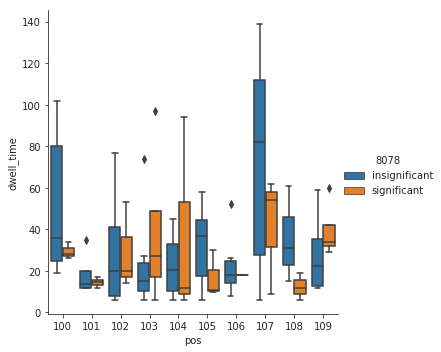

In [21]:
lo, hi = 100, 110
to_plot = long.query('@lo <= pos < @hi').sample(100).copy()
_ = sns.catplot(
    x='pos',
    y='dwell_time',
    hue=8078,
    kind='box',
    data=to_plot
)

In [179]:
def format_ax(ax):
    '''
    Format axes object appropriately for graphs of dwell-time distributions
    
    Arguments:
        ax (matplotlib axes object)
        
    Returns:
        None
    '''
    ax.set_ylim(1, 300)
    ymin, ymax = ax.get_ylim()
    ax.vlines([5, 15], ymin=ymin, ymax=ymax, color=['g', 'red'], linewidth=3, linestyle='dotted', alpha=1)
    ax.grid(b=True, which='both', axis='y')
    ax.set_yscale('log')
    ax.set_title('Near nucleotide {}'.format(site), fontsize=30)
    ax.set_ylabel('Dwell time', fontsize=20)
    ax.set_xlabel('Nucleotide position (zero-based)', fontsize=20)
    ax.legend(loc='lower center', fontsize=16)

def format_fig(fig):
    '''
    Format figure object appropriately for a subplot graph of dwell-time
    distributions near the three modification sites.
    
    Arguments:
        ax (matplotlib figure object)
        
    Returns:
        None
    '''
    fig.suptitle('Dwell-time distributions (significance threshold: $p$ < 0.05)', fontsize=30)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

def make_catplots(sites, fig, axes, **kwargs):
    '''
    Plot dwell-times around each of the three specified sites.
    
    Arguments:
        sites (list of ints of length 3): sites around which to make plots
        fig (matplotlib figures object): draw onto this fig
        ax (matplotlib axes object): draw onto these axis objects
    
    Returns:
        fig
        ax
    '''

    for site, ax in zip(sites, axes):
        lo, hi = site-5, site+15
        to_plot = long.query('@lo <= pos < @hi')

        _ = sns.catplot(ax=ax, **kwargs)

        format_ax(ax)

    # See this Stackoverflow post for an explanation of why plt.close is necessary
    # https://stackoverflow.com/questions/54959764/seaborn-factorplot-generates-extra-empty-plots-below-actual-plot
    for x in range(2,5):
        plt.close(x)

    format_fig(fig)

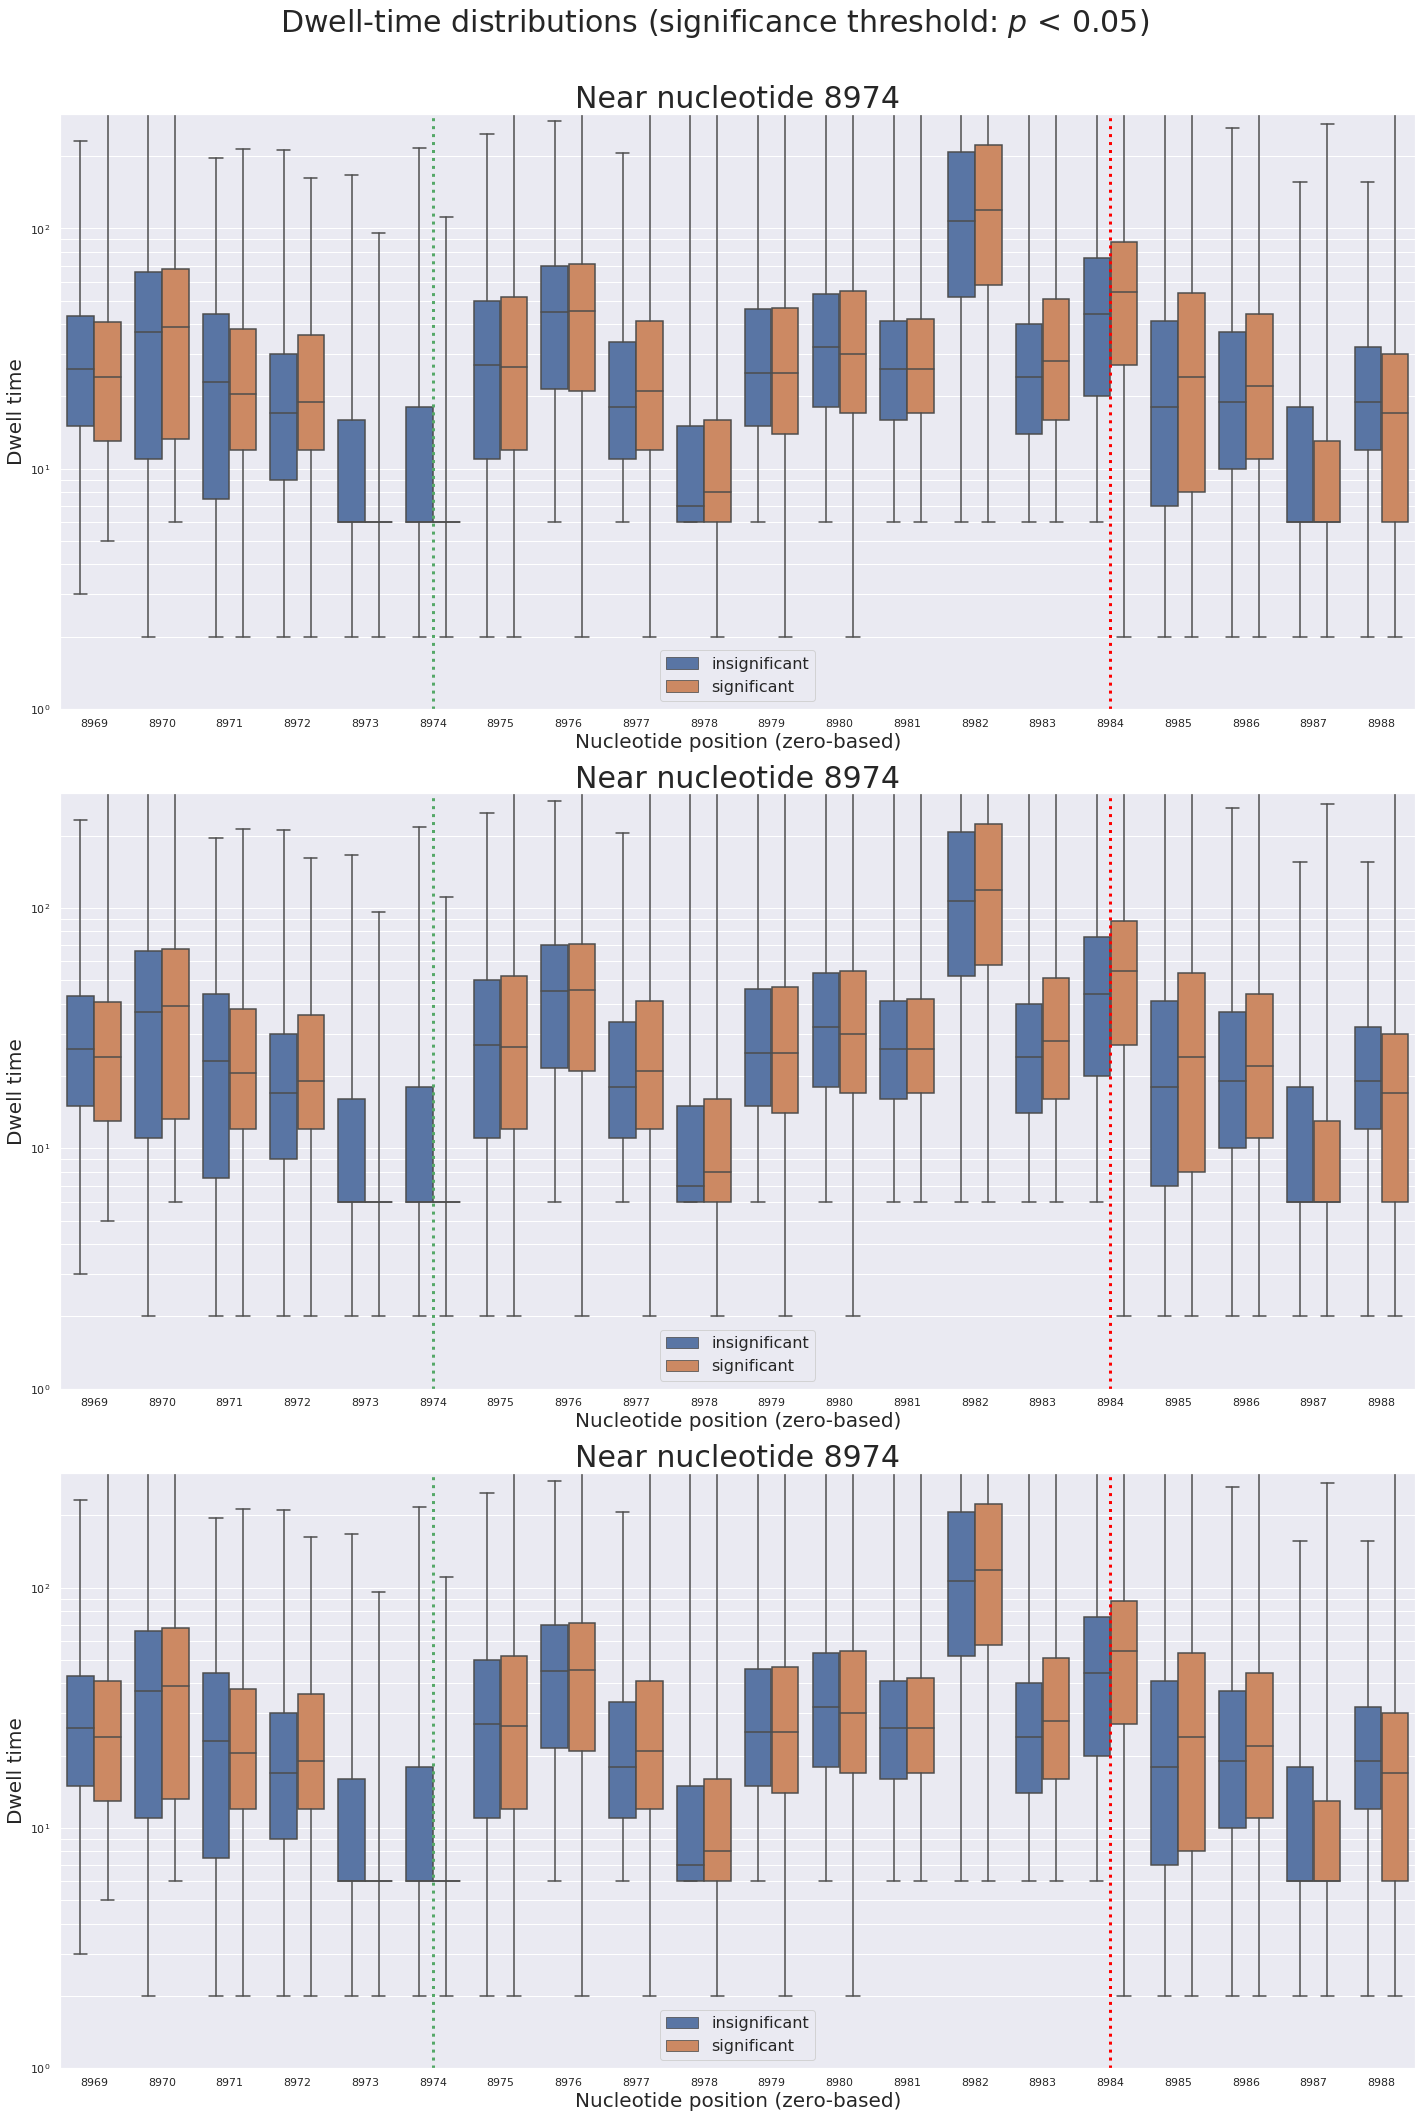

In [186]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,30), sharey=True)
make_catplots(
    sites=putative_sites,
    fig=fig,
    axes=axes,
    x='pos',
    y='dwell_time',
    hue=site,
    kind='box', whis=(0,100),
    data=to_plot,
)
plt.draw()
fig.savefig('box_plots_signif_vs_insignif')

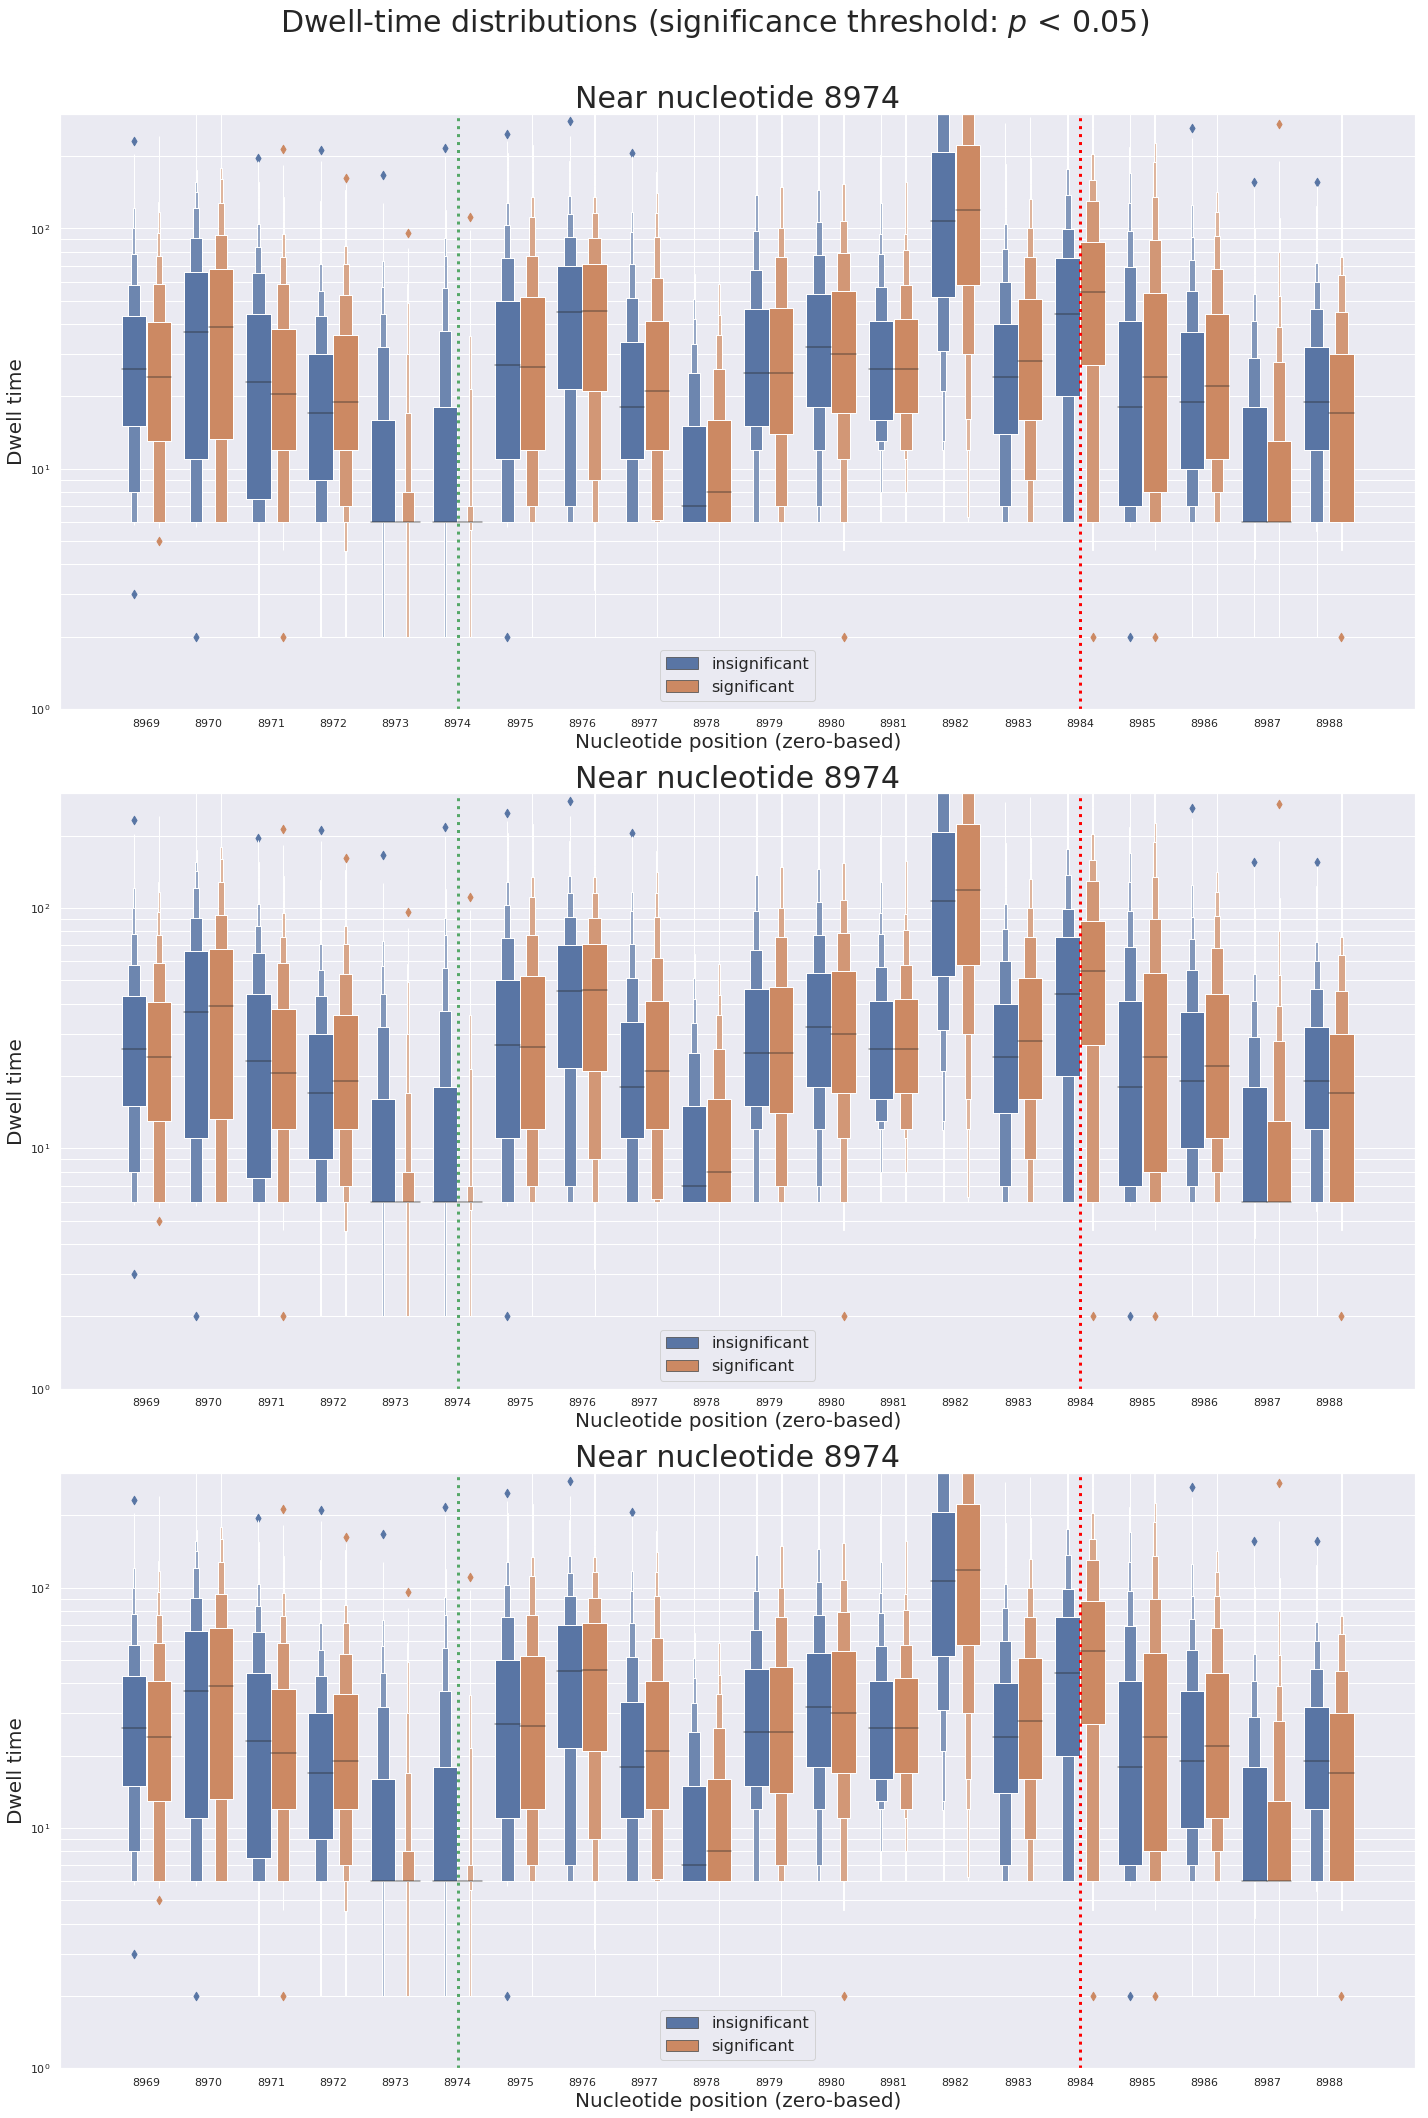

In [187]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,30), sharey=True)
make_catplots(
    sites=putative_sites,
    fig=fig,
    axes=axes,
    x='pos',
    y='dwell_time',
    hue=site,
    kind='boxen',
    data=to_plot,
)
plt.draw()
fig.savefig('boxen_plots_signif_vs_insignif')